In [2]:
import numpy as np
import pandas as pd

from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import os
import sys
BASE_PATH = os.path.realpath('..')
DATASETS_DIR = os.path.join(BASE_PATH, 'datasets')
LIB_DIR = os.path.join(BASE_PATH,'lib')
if LIB_DIR not in sys.path:
    sys.path.append(LIB_DIR)

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from importlib import reload

/root/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/root/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/root/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


/root/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [3]:
import fca_interp as fcai

In [4]:
from utils_ import powerset

In [5]:
from importlib import reload

In [6]:
from sklearn.datasets import load_boston

/root/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



# Attribute Information:

Input variables:

__bank client data:__
1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')

__related with the last contact of the current campaign:__
8. contact: contact communication type (categorical: 'cellular','telephone')
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

__other attributes:__
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

__social and economic context attributes__
16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric)
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

__Output variable (desired target):__
21. y - has the client subscribed a term deposit? (binary: 'yes','no')



In [172]:
real_feats = ['age', 'default', 'housing', 'loan', 'campaign', 'pdays', 'previous', 'balance','day']
cat_feats  = ['job', 'marital', 'education', 'contact', 'month', 'poutcome',]

In [175]:
bank_ds.to_csv('bank_ds_new.csv')
bank_ds = pd.read_csv('bank_ds_new.csv', index_col=0)

In [170]:
bank_ds.index = bank_ds.index.astype(str)

In [11]:
import fca_interp as fcai

In [12]:
fcai = reload(fcai)

In [171]:
flg = bank_ds['preds']==1

In [13]:
mvcntx_full = fcai.MultiValuedContext(bank_ds[real_feats[0:2]], cat_attrs=cat_feats)
mvcntx = fcai.MultiValuedContext(bank_ds.loc[flg, real_feats[0:2]], cat_attrs=[])#cat_feats)

In [14]:
mvcntx._cat_attrs_idxs

[]

In [15]:
binarizer = fcai.Binarizer()

In [16]:
round_coefs = {'age': 0,
 'default': 0,
 'housing': 0,
 'loan': 0,
 'campaign': 0,
 'pdays': 0,
 'previous': 0,
 'balance': 0,
 'day': 0}

In [17]:
ths = {}
for f in real_feats:
    ths[f] = sorted(bank_ds.loc[flg, f].unique())
cases = {}

In [18]:
bin_ds, forder = binarizer.binarize_ds(bank_ds[cat_feats+real_feats], cat_feats, ths, cases)
bin_ds.shape

(4521, 726)

In [19]:
bin_ds[flg].drop_duplicates().T.drop_duplicates().T.shape

(160, 706)

In [20]:
def get_negative_support(bin_ds, flg, fs=None, drop_negative_duplicates=False):
    fs = fs if fs is not None else bin_ds.columns
    fs = list(fs)
    pos_examples = bin_ds.loc[flg, fs].astype(int)
    neg_examples = bin_ds.loc[~flg, fs].astype(int)
    
    pos_examples = pos_examples.drop_duplicates()            
    if drop_negative_duplicates:
        neg_examples = neg_examples.drop_duplicates()
        coefs = [1]*len(neg_examples)
    else:
        neg_examples = neg_examples.pivot_table(index=fs, aggfunc='size').reset_index()
        coefs = neg_examples[0]
        neg_examples = neg_examples.drop(0, 1)
        
    cross = pos_examples.dot(neg_examples.T)    
    #cross_same = (cross==neg_examples.sum(1))&((cross.T==pos_examples.sum(1)).T)
    cross_same = (cross.T==pos_examples.sum(1)).T # if g_+` 
    neg_support = (cross_same.any(0) * coefs).sum()
    return neg_support

In [21]:
def is_feats_strong(bin_ds, flg, fs=None):
    fs = fs if fs is not None else bin_ds.columns
    neg_support = get_negative_support(bin_ds, flg, fs, drop_negative_duplicates=True)
    return neg_support==0

In [22]:
is_feats_strong(bin_ds, flg)

True

In [23]:
for i in [0,1]:
    s = bin_ds.columns[bin_ds.mean()==i]
    bin_ds = bin_ds.drop(s, 1)

In [24]:
is_feats_strong(bin_ds, flg)

True

In [25]:
bin_ds_pos = bin_ds.loc[flg]
bin_ds_neg = bin_ds.loc[~flg]

In [26]:
feat_pos_supp = bin_ds_pos.sum().sort_values(ascending=False)
feat_pos_supp

balance__geq__-247     160
default__leq__0        160
previous__leq__14      160
balance__leq__14220    160
campaign__leq__9       160
                      ... 
balance__leq__-247       1
pdays__geq__761.0        1
campaign__geq__9         1
age__geq__87             1
day__geq__31             1
Length: 713, dtype: int64

In [27]:
best_general_feats = feat_pos_supp[feat_pos_supp>=70].index
len(best_general_feats), get_negative_support(bin_ds[best_general_feats], flg)

(386, 0)

In [28]:
def is_feats_strong_on_context(bin_ds, flg, fs=None ):
    fs = bin_ds.columns if fs is not None else fs
    cntx = fcai.BinaryContext(bin_ds.loc[flg, short_feats])
    cntx_full = fcai.BinaryContext(bin_ds[short_feats])
    ss = []
    for g in tqdm(cntx._objs):
        int_ = cntx.get_intent([g])
        ext_ = cntx.get_extent(int_, is_full=True)
        ext_full = cntx_full.get_extent(int_, is_full=True)
        strongness = len(ext_)/len(ext_full) if len(ext_)>0 else 0
        ss.append(ss)
    return np.mean(ss)

In [30]:
bin_ds_short = bin_ds[best_general_feats]
bin_ds_short.shape

(4521, 386)

In [31]:
feat_strongness = bin_ds_short.loc[flg].sum()/bin_ds_short.sum()
feat_strongness = feat_strongness.sort_values(ascending=False)
feat_strongness.head()

poutcome__is__success    0.697674
pdays__leq__189.0        0.237164
pdays__leq__185.0        0.234848
pdays__leq__188.0        0.234568
pdays__leq__187.0        0.234414
dtype: float64

In [32]:
best_strongest_feats = feat_strongness[feat_strongness>=0.03].index
len(best_strongest_feats), get_negative_support(bin_ds_short, flg, best_strongest_feats)

(329, 0)

In [33]:
bin_ds_short = bin_ds[best_strongest_feats]

In [34]:
feat_strongness = bin_ds_short.loc[flg].sum()/bin_ds_short.sum()
feat_strongness = feat_strongness.sort_values(ascending=False)
feat_strongness.head()

poutcome__is__success    0.697674
pdays__leq__189.0        0.237164
pdays__leq__185.0        0.234848
pdays__leq__188.0        0.234568
pdays__leq__187.0        0.234414
dtype: float64

In [28]:
bin_ds_pos = bin_ds.loc[flg]
bin_ds_neg = bin_ds.loc[~flg]

In [36]:
with open('short_feats.txt', 'r') as f:
    short_feats = f.read().split(',')

In [37]:
bin_pos_ = bin_ds.loc[flg, short_feats].drop_duplicates()
bin_neg_ = bin_ds.loc[~flg, short_feats].drop_duplicates()

In [38]:
bin_pos_.shape

(159, 35)

In [39]:
bin_neg_.shape

(3629, 35)

In [40]:
for idx, row in tqdm(bin_pos_.iterrows(),total=len(bin_pos_)):
    neg_sup = (bin_neg_==row).all(1).sum()
    assert neg_sup==0, f'Row {idx} is not strong'

In [43]:
from sklearn.metrics import accuracy_score

Чёрный ящик сильно недопредсказывает целевую переменную

In [87]:
fcai = reload(fcai)

In [88]:
bin_ds.index = bin_ds.index.astype(str)

In [89]:
cntx_full = fcai.BinaryContext(bin_ds[short_feats], y_true=bank_ds['y'], y_pred=bank_ds['preds'])

In [90]:
cntx = fcai.BinaryContext(bin_ds[flg][short_feats], y_true=bank_ds[flg]['y'], y_pred=bank_ds[flg]['preds'], )

In [91]:
fm = fcai.FormalManager(cntx, task_type='binary classification', cat_feats=cat_feats, context_full=cntx_full )

In [92]:
fm.construct_concepts(algo='CBO', max_num_attrs=6, use_tqdm=True, calc_metrics=False)

In [93]:
import pickle

In [94]:
exts = []
for c in tqdm(fm.get_concepts()):
    exts.append(c.get_extent())

In [95]:
with open('extents_list.txt','w') as f:
    for ext in exts:
        f.write(','.join(ext)+'\n')

In [96]:
fm.calc_strongness(cntx_full, use_tqdm=True)

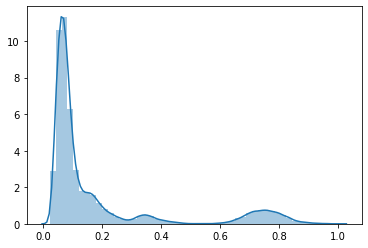

In [97]:
s = pd.Series({c._idx: c._metrics['strongness'] for c in fm.get_concepts()})
sns.distplot(s)

In [98]:
s.sort_values()

68564    0.022956
57493    0.024691
68558    0.025084
40635    0.025442
68516    0.025915
           ...   
62215    0.965517
68850    1.000000
63569    1.000000
62208    1.000000
66347    1.000000
Length: 68851, dtype: float64

In [99]:
def calc_cover_of_concepts(concepts):
    return set([str(g) for c in concepts for g in c.get_extent()])

In [100]:
def get_min_concepts(concepts, use_tqdm=True):
    concepts = sorted(concepts, key=lambda c: -len(c.get_extent()))
    for i in tqdm(range(len(concepts)), disable=not use_tqdm):
        if i >= len(concepts):
            break
        
        c = concepts[i]
        lns = set([c_ for c_ in concepts if c_!=c and c_.is_subconcept_of(c)])
        concepts = [c_ for c_ in concepts if c_ not in lns]
    return concepts

In [101]:
flg.index = flg.index.astype(str)

In [147]:
strong_concepts = [c for c in fm.get_concepts() if c._metrics['strongness']>=0.8]
len(strong_concepts)

1967

In [142]:
mc = get_min_concepts(strong_concepts)

In [145]:
cover = len(calc_cover_of_concepts(strong_concepts))
cover, cover/len(cntx.get_objs(is_full=True))*100

(90, 56.25)

In [148]:
fm._concepts = {c for c in fm._concepts if c._metrics['strongness']>=0.8}

In [149]:
fm.construct_lattice(use_tqdm=True)

In [150]:
fm.calc_stability_approx(use_tqdm=True)

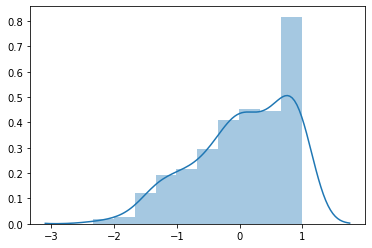

In [151]:
sns.distplot([c._metrics['stab_min_bound'] for c in fm.get_concepts()])

In [161]:
cncpts = fm.get_concepts()
msb = 0.8
sb = 0.9
cncpts = [c for c in cncpts if c._metrics['stab_min_bound'] and c._metrics['stab_min_bound']>=msb]
cncpts = [c for c in cncpts if c._metrics['strongness'] and c._metrics['strongness']>=sb]
min_concepts = get_min_concepts(cncpts)
cover = len(calc_cover_of_concepts(min_concepts))
print(f"min stab bound: {msb}, min strongness: {sb}, n min hyps: {len(min_concepts)}, cover of hyps: {cover} ({cover/flg.sum():.2%})")


min stab bound: 0.8, min strongness: 0.9, n min hyps: 2, cover of hyps: 42 (26.25%)


In [162]:
min_concepts = sorted(min_concepts, key=lambda c: (-len(c.get_extent()),-c._metrics['strongness']))

In [159]:
min_concepts

[Concept 63051
 level: 2
 extent (len: 24): 110, 328, 540, 619, 1048, 1181, 1186, 1485, 1695, 2049, 2122, 2449, 2847, 3005, 3088, 3176, 3250, 3256, 3695, 3896, 3931, 3978, 4093, 4159
 intent (len: 6): poutcome__is__success, contact__not__unknown, housing__leq__0, day__geq__10, previous__geq__3, balance__geq__94
 new extent (len: 8): 1186, 619, 3250, 3978, 4093, 2449, 3256, 3695
 new_intent (len: 0): ∅
 lower neighbours (len: 1): 68593
 upper neighbours (len: 2): 20225, 20229
 metric strongness = 0.9230769230769231
 metric stab_min_bound = 0.99609375
 metric stab_max_bound = 0.99609375
 metric log_stab_min_bound = 8.0
 metric log_stab_max_bound = 8.0
 metric lstab_min_bound = -27.0,
 Concept 66340
 level: 2
 extent (len: 23): 98, 110, 233, 540, 855, 880, 1166, 1485, 1736, 1754, 2188, 2372, 2539, 3088, 3243, 3370, 3385, 3498, 3684, 4009, 4093, 4229, 4458
 intent (len: 6): poutcome__is__success, contact__not__unknown, month__not__may, day__geq__10, marital__not__married, contact__is__cell

In [551]:
selected_hyps = []
n_added = []
n_covered = []
for i in tqdm(range(len(min_concepts))):
    cncpts_to_check = [c for c in min_concepts if c not in selected_hyps]
    if len(cncpts_to_check)==0:
        break
    cover = calc_cover_of_concepts(selected_hyps)
    for c in cncpts_to_check:
        c._metrics['n_uncovered'] = len([g for g in c.get_extent() if g not in cover])
    cncpts_to_check = sorted(cncpts_to_check, key=lambda c: (-c._metrics['n_uncovered'], -c._metrics['strongness']))
    n_ = cncpts_to_check[0]._metrics['n_uncovered']
    if n_==0:
        break
    selected_hyps.append(cncpts_to_check[0])
    n_added.append(n_)
    n_covered.append(len(calc_cover_of_concepts(selected_hyps)))

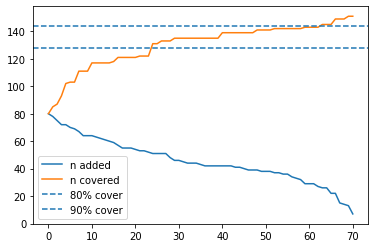

In [556]:
plt.plot(n_added, label='n added')
plt.plot(n_covered, label='n covered')
plt.axhline(flg.sum()*0.8, linestyle='--', label='80% cover')
plt.axhline(flg.sum()*0.9, linestyle='--', label='90% cover')
plt.legend()

In [583]:
t_80 = (np.array(n_covered)>=flg.sum()*0.8).argmax()+1
t_90 = (np.array(n_covered)>=flg.sum()*0.9).argmax()+1
t_80, t_90

(25, 64)

In [584]:
len(calc_cover_of_concepts(selected_hyps[:t_80]))/flg.sum()

0.81875

In [585]:
selected_hyps_80 = selected_hyps[:t_80]

In [591]:
for c in selected_hyps_80:
    print(f"* {c.get_id():5.0f}) {len(c.get_extent())} objs, strong: {c._metrics['strongness']:.2f}: "+" & ".join(c.get_intent()))
    print()

* 12486) 80 objs, strong: 0.76: job__not__self-employed & marital__not__divorced & education__not__primary & education__not__unknown & contact__is__cellular & month__not__feb & poutcome__not__unknown

*  8838) 78 objs, strong: 0.78: job__not__blue-collar & job__not__self-employed & marital__not__divorced & education__not__primary & education__not__unknown & contact__is__cellular & poutcome__not__unknown

*  9487) 75 objs, strong: 0.75: job__not__blue-collar & marital__not__divorced & education__not__primary & education__not__unknown & contact__is__cellular & month__not__feb & poutcome__not__unknown

* 13711) 72 objs, strong: 0.78: job__not__blue-collar & job__not__self-employed & marital__not__divorced & education__not__unknown & contact__is__cellular & month__not__may & month__not__feb & poutcome__not__unknown

*  8454) 72 objs, strong: 0.76: job__not__blue-collar & education__not__unknown & contact__is__cellular & month__not__may & month__not__apr & month__not__feb & poutcome__not__u

In [712]:
min([c._metrics['strongness'] for c in selected_hyps_80])

0.75

In [722]:
bin_ds_pos[selected_hyps_80[0].get_intent()].all(1).sum()

80

In [726]:
bin_ds[selected_hyps_80[0].get_intent()].all(1).sum()

488

In [714]:
concepts_ds

,job__not__self-employed&marital__not__divorced&education__not__primary&education__not__unknown&contact__is__cellular&month__not__feb&poutcome__not__unknown,job__not__blue-collar&job__not__self-employed&marital__not__divorced&education__not__primary&education__not__unknown&contact__is__cellular&poutcome__not__unknown,job__not__blue-collar&marital__not__divorced&education__not__primary&education__not__unknown&contact__is__cellular&month__not__feb&poutcome__not__unknown,job__not__blue-collar&job__not__self-employed&marital__not__divorced&education__not__unknown&contact__is__cellular&month__not__may&month__not__feb&poutcome__not__unknown,job__not__blue-collar&education__not__unknown&contact__is__cellular&month__not__may&month__not__apr&month__not__feb&poutcome__not__unknown,job__not__blue-collar&job__not__self-employed&education__not__primary&education__not__unknown&contact__is__cellular&month__not__may&month__not__feb&poutcome__not__unknown,job__not__blue-collar&job__not__self-employed&education__not__primary&education__not__unknown&contact__is__cellular&month__not__apr&month__not__feb&poutcome__not__unknown,job__not__management&job__not__blue-collar&job__not__self-employed&education__not__unknown&month__not__may&month__not__apr&month__not__feb&poutcome__not__unknown,job__not__blue-collar&job__not__self-employed&job__not__technician&education__not__primary&education__not__unknown&contact__is__cellular&month__not__feb&poutcome__not__unknown,job__not__self-employed&education__not__primary&education__not__unknown&contact__is__cellular&month__not__may&month__not__apr&month__not__feb&poutcome__not__unknown,...,job__not__management&job__not__blue-collar&job__not__self-employed&job__not__technician&education__not__unknown&month__not__may&month__not__feb&poutcome__not__unknown,job__not__management&job__not__blue-collar&job__not__self-employed&job__not__technician&education__not__primary&education__not__unknown&month__not__feb&poutcome__not__unknown,job__not__management&job__not__blue-collar&job__not__self-employed&job__not__technician&education__not__primary&education__not__unknown&month__not__apr&poutcome__not__unknown,job__not__blue-collar&job__not__self-employed&job__not__technician&marital__not__divorced&education__not__unknown&contact__is__cellular&month__not__apr&month__not__feb&poutcome__not__unknown,job__not__management&job__not__blue-collar&job__not__self-employed&education__not__unknown&contact__is__cellular&month__not__may&month__not__feb&month__not__aug&poutcome__not__unknown,job__not__blue-collar&job__not__self-employed&job__not__technician&education__not__primary&contact__is__cellular&month__not__may&month__not__apr&month__not__feb&poutcome__not__unknown,job__not__self-employed&marital__not__single&marital__not__divorced&education__not__unknown&contact__is__cellular&month__not__may&month__not__feb&poutcome__not__unknown,job__not__blue-collar&job__not__self-employed&marital__not__divorced&contact__is__cellular&month__not__may&month__not__apr&month__not__feb&month__not__aug&poutcome__not__unknown,job__not__self-employed&job__not__technician&marital__not__divorced&education__not__primary&education__not__unknown&contact__is__cellular&month__not__may&month__not__apr&poutcome__not__unknown,job__not__management&job__not__blue-collar&job__not__self-employed&job__not__technician&education__not__unknown&contact__is__cellular&month__not__may&month__not__apr&month__not__feb&month__not__aug
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,True,True,True,False,False,False,True,False,True,False,...,False,True,True,True,False,False,False,False,False,False
2,True,True,True,True,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,

In [603]:
concepts_ds = pd.DataFrame()
for c in selected_hyps_80:
    concepts_ds['&'.join(c.get_intent())] = bin_ds[c.get_intent()].all(1)

In [604]:
concepts_ds

,job__not__self-employed&marital__not__divorced&education__not__primary&education__not__unknown&contact__is__cellular&month__not__feb&poutcome__not__unknown,job__not__blue-collar&job__not__self-employed&marital__not__divorced&education__not__primary&education__not__unknown&contact__is__cellular&poutcome__not__unknown,job__not__blue-collar&marital__not__divorced&education__not__primary&education__not__unknown&contact__is__cellular&month__not__feb&poutcome__not__unknown,job__not__blue-collar&job__not__self-employed&marital__not__divorced&education__not__unknown&contact__is__cellular&month__not__may&month__not__feb&poutcome__not__unknown,job__not__blue-collar&education__not__unknown&contact__is__cellular&month__not__may&month__not__apr&month__not__feb&poutcome__not__unknown,job__not__blue-collar&job__not__self-employed&education__not__primary&education__not__unknown&contact__is__cellular&month__not__may&month__not__feb&poutcome__not__unknown,job__not__blue-collar&job__not__self-employed&education__not__primary&education__not__unknown&contact__is__cellular&month__not__apr&month__not__feb&poutcome__not__unknown,job__not__management&job__not__blue-collar&job__not__self-employed&education__not__unknown&month__not__may&month__not__apr&month__not__feb&poutcome__not__unknown,job__not__blue-collar&job__not__self-employed&job__not__technician&education__not__primary&education__not__unknown&contact__is__cellular&month__not__feb&poutcome__not__unknown,job__not__self-employed&education__not__primary&education__not__unknown&contact__is__cellular&month__not__may&month__not__apr&month__not__feb&poutcome__not__unknown,...,job__not__management&job__not__blue-collar&job__not__self-employed&job__not__technician&education__not__unknown&month__not__may&month__not__feb&poutcome__not__unknown,job__not__management&job__not__blue-collar&job__not__self-employed&job__not__technician&education__not__primary&education__not__unknown&month__not__feb&poutcome__not__unknown,job__not__management&job__not__blue-collar&job__not__self-employed&job__not__technician&education__not__primary&education__not__unknown&month__not__apr&poutcome__not__unknown,job__not__blue-collar&job__not__self-employed&job__not__technician&marital__not__divorced&education__not__unknown&contact__is__cellular&month__not__apr&month__not__feb&poutcome__not__unknown,job__not__management&job__not__blue-collar&job__not__self-employed&education__not__unknown&contact__is__cellular&month__not__may&month__not__feb&month__not__aug&poutcome__not__unknown,job__not__blue-collar&job__not__self-employed&job__not__technician&education__not__primary&contact__is__cellular&month__not__may&month__not__apr&month__not__feb&poutcome__not__unknown,job__not__self-employed&marital__not__single&marital__not__divorced&education__not__unknown&contact__is__cellular&month__not__may&month__not__feb&poutcome__not__unknown,job__not__blue-collar&job__not__self-employed&marital__not__divorced&contact__is__cellular&month__not__may&month__not__apr&month__not__feb&month__not__aug&poutcome__not__unknown,job__not__self-employed&job__not__technician&marital__not__divorced&education__not__primary&education__not__unknown&contact__is__cellular&month__not__may&month__not__apr&poutcome__not__unknown,job__not__management&job__not__blue-collar&job__not__self-employed&job__not__technician&education__not__unknown&contact__is__cellular&month__not__may&month__not__apr&month__not__feb&month__not__aug
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,True,True,True,False,False,False,True,False,True,False,...,False,True,True,True,False,False,False,False,False,False
2,True,True,True,True,False,True,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,

In [607]:
concepts_ds.shape

(4521, 25)

In [690]:
cntx_cncpts_full = fcai.BinaryContext(concepts_ds)
cntx_cncpts = fcai.BinaryContext(concepts_ds[flg])
cntx_cncpts_neg = fcai.BinaryContext(~concepts_ds[flg])
cntx_cncpts_neg_full = fcai.BinaryContext(~concepts_ds)

In [613]:
fm_cncpts_neg = fcai.FormalManager(cntx_cncpts_neg,)

In [614]:
fm_cncpts_neg.construct_concepts()

In [617]:
len(fm_cncpts_neg.get_concepts())

49568

In [619]:
cntx_cncpts_neg._objs

array(['13', '49', '70', '83', '110', '156', '199', '233', '289', '323',
       '347', '412', '464', '477', '503', '619', '849', '855', '880',
       '970', '1109', '1111', '1124', '1166', '1181', '1276', '1349',
       '1374', '1485', '1736', '1754', '1767', '1862', '1915', '1928',
       '2049', '2251', '2332', '2433', '2539', '2675', '3088', '3297',
       '3835', '3843', '3896', '3930', '4229', '4232'], dtype='<U4')

In [622]:
for c in tqdm(fm_cncpts_neg.get_concepts()):
    c._extent = [g for g in cntx_cncpts_neg._objs_full if int(g) not in c._extent]

In [643]:
for c in tqdm(fm_cncpts_neg.get_concepts()):
    s = concepts_ds.loc[flg, c.get_intent()].any(1)
    s = s[s].index
    c._extent = list(s)
    s_full = concepts_ds[c.get_intent()].any(1)
    s_full = s_full[s_full].index
    c._metrics['strongness'] = len(s)/len(s_full)

In [681]:
ext_ = cntx_cncpts_neg.get_extent(c.get_intent(),)
ext_ = [g for g in cntx_cncpts_neg._objs_full if g not in ext_]

In [687]:
c.get_extent()

[49,
 70,
 83,
 110,
 156,
 199,
 233,
 289,
 323,
 328,
 347,
 412,
 464,
 492,
 540,
 619,
 684,
 849,
 855,
 880,
 941,
 1048,
 1056,
 1060,
 1076,
 1109,
 1111,
 1124,
 1166,
 1181,
 1186,
 1303,
 1312,
 1342,
 1349,
 1425,
 1437,
 1469,
 1695,
 1736,
 1760,
 1767,
 1862,
 1904,
 1905,
 1915,
 1928,
 1952,
 2049,
 2055,
 2122,
 2176,
 2188,
 2212,
 2213,
 2251,
 2332,
 2372,
 2431,
 2433,
 2444,
 2449,
 2471,
 2486,
 2539,
 2583,
 2665,
 2675,
 2696,
 2847,
 2969,
 2988,
 2992,
 3005,
 3027,
 3064,
 3088,
 3202,
 3239,
 3243,
 3250,
 3256,
 3301,
 3317,
 3331,
 3370,
 3385,
 3498,
 3502,
 3527,
 3586,
 3589,
 3658,
 3684,
 3695,
 3743,
 3751,
 3835,
 3843,
 3874,
 3896,
 3930,
 3931,
 3932,
 3978,
 4009,
 4093,
 4159,
 4160,
 4215,
 4433,
 4458,
 4465]

In [689]:
cntx_cncpts_neg._objs_full

array(['13', '36', '49', '70', '83', '98', '110', '129', '156', '199',
       '233', '289', '323', '328', '347', '412', '456', '464', '477',
       '492', '503', '540', '619', '684', '849', '855', '880', '941',
       '944', '970', '984', '1048', '1056', '1060', '1076', '1109',
       '1111', '1113', '1124', '1166', '1181', '1186', '1230', '1276',
       '1303', '1312', '1342', '1349', '1374', '1415', '1425', '1437',
       '1467', '1469', '1485', '1672', '1695', '1736', '1754', '1760',
       '1767', '1862', '1904', '1905', '1915', '1927', '1928', '1940',
       '1952', '2014', '2049', '2055', '2122', '2176', '2188', '2212',
       '2213', '2251', '2332', '2372', '2421', '2431', '2433', '2444',
       '2449', '2471', '2477', '2486', '2539', '2583', '2665', '2675',
       '2685', '2696', '2773', '2780', '2821', '2845', '2847', '2962',
       '2969', '2988', '2992', '3005', '3027', '3064', '3088', '3176',
       '3202', '3239', '3243', '3248', '3250', '3256', '3297', '3301',
       '331

In [686]:
cntx_cncpts_neg.get_extent(c.get_intent())

['13',
 '477',
 '503',
 '970',
 '1276',
 '1374',
 '1485',
 '1754',
 '3297',
 '4229',
 '4232']

In [692]:
for c in tqdm(fm_cncpts_neg.get_concepts()):
    ext_ = cntx_cncpts_neg.get_extent(c.get_intent(),)
    ext_ = [int(g) for g in cntx_cncpts_neg._objs_full if g not in ext_]
    c._extent = ext_
    
    ext_full = cntx_cncpts_neg_full.get_extent(c.get_intent())
    ext_full = [int(g) for g in cntx_cncpts_neg_full._objs_full if g not in ext_full]
    c._metrics['strongness'] = len(ext_)/len(ext_full) if len(ext_)>0 else 0

In [705]:
concepts_ds.iloc[:,0].loc[flg].sum()

80

In [707]:
concepts_ds.iloc[:,0].sum()

488

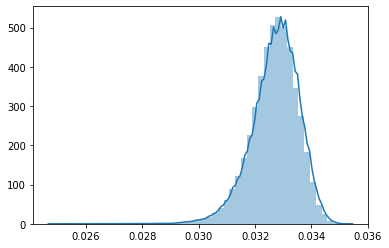

In [697]:
sns.distplot([c._metrics['strongness'] for c in fm_cncpts_neg.get_concepts()])

In [654]:
%%timeit
ext_ = cntx_cncpts_neg.get_extent(c.get_intent(),)
ext_ = [g for g in cntx_cncpts_neg._objs_full if g not in ext_]

281 µs ± 54.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [675]:
%%timeit
s_ = concepts_ds.loc[flg, c.get_intent()].any(1)
ext_ = s_[s_].index

1.77 ms ± 387 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [644]:
cntx_cncpts_full

Num of objects: 72, Num of attrs: 25
Objects (len: 72): 0, 1, 2, 3, 5,...
Attrs (len: 25): job__not__self-employed&marital__not__divorced&education__not__primary&education__not__unknown&contact__is__cellular&month__not__feb&poutcome__not__unknown, job__not__blue-collar&job__not__self-employed&marital__not__divorced&education__not__primary&education__not__unknown&contact__is__cellular&poutcome__not__unknown, job__not__blue-collar&marital__not__divorced&education__not__primary&education__not__unknown&contact__is__cellular&month__not__feb&poutcome__not__unknown, job__not__blue-collar&job__not__self-employed&marital__not__divorced&education__not__unknown&contact__is__cellular&month__not__may&month__not__feb&poutcome__not__unknown, job__not__blue-collar&education__not__unknown&contact__is__cellular&month__not__may&month__not__apr&month__not__feb&poutcome__not__unknown,...

In [636]:
s = concepts_ds.loc[flg, c._intent].any(1)
s = s[s]

In [640]:
[g for g in c.get_extent() if int(g) in s.index]

['70',
 '83',
 '110',
 '199',
 '233',
 '289',
 '323',
 '347',
 '412',
 '464',
 '619',
 '849',
 '855',
 '880',
 '1109',
 '1111',
 '1124',
 '1166',
 '1181',
 '1349',
 '1736',
 '1767',
 '1862',
 '1915',
 '1928',
 '2049',
 '2251',
 '2332',
 '2433',
 '2539',
 '2675',
 '3088',
 '3835',
 '3843',
 '3896',
 '3930']

In [637]:
s

49      True
70      True
83      True
110     True
156     True
        ... 
4160    True
4215    True
4433    True
4458    True
4465    True
Length: 113, dtype: bool

In [624]:
cncpts_ = sorted(fm_cncpts_neg.get_concepts(), key=lambda c: len(c.get_extent()))

In [625]:
cncpts_

[Concept 16439
 
 extent (len: 45): 70, 110, 199, 233, 289, 323, 347, 412, 464, 477, 503, 619, 849, 855, 880, 970, 1109, 1111, 1124, 1166, 1181, 1276, 1349, 1374, 1485, 1736, 1754, 1767, 1862, 1915, 1928, 2049, 2251, 2332, 2433, 2539, 2675, 3088, 3297, 3835, 3843, 3896, 3930, 4229, 4232
 intent (len: 7): job__not__blue-collar&job__not__self-employed&marital__not__single&contact__is__cellular&month__not__may&month__not__apr&month__not__feb&poutcome__not__unknown, job__not__blue-collar&job__not__self-employed&job__not__technician&education__not__unknown&contact__is__cellular&month__not__may&month__not__feb&poutcome__not__unknown, job__not__self-employed&marital__not__single&education__not__unknown&contact__is__cellular&month__not__may&month__not__apr&month__not__feb&poutcome__not__unknown, job__not__blue-collar&job__not__self-employed&job__not__technician&education__not__primary&contact__is__cellular&month__not__may&month__not__apr&month__not__feb&poutcome__not__unknown, job__not__self-e

In [623]:
cncpts_

NameError: name 'cncpts_' is not defined